In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

# 加入下述代码！可能！是因为torch包中包含了名为libiomp5md.dll的文件，
# 与Anaconda环境中的同一个文件出现了某种冲突，所以需要删除一个。
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
features = pd.read_csv('data1.csv')

# 查看数据（默认查看前5行）
# https://blog.csdn.net/qq_40305043/article/details/104851766
features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [3]:
print(type(features))

<class 'pandas.core.frame.DataFrame'>


数据表中
* year,moth,day,week分别表示的具体的时间
* temp_2：前天的最高温度值
* temp_1：昨天的最高温度值
* average：在历史中，每年这一天的平均最高温度值
* actual：这就是我们的标签值了，当天的真实最高温度
* friend：朋友预测值（意义不大）

In [4]:
print('数据维度:', features.shape)

数据维度: (348, 9)


In [5]:
# 处理时间数据
import datetime

# 分别得到年，月，日
years = features['year']
months = features['month']
days = features['day']

# datetime格式
dates = [
    str(int(year)) + '-' + str(int(month)) + '-' + str(int(day))
    for year, month, day in zip(years, months, days)
]

# datetime模块的datetime对象提供的strptime方法可以将字符串转为datetime对象，转换时要求字符串内容符合指定的格式。
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

In [6]:
# 显示前5行的数据
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

In [7]:
print(type(datetime))

<class 'module'>


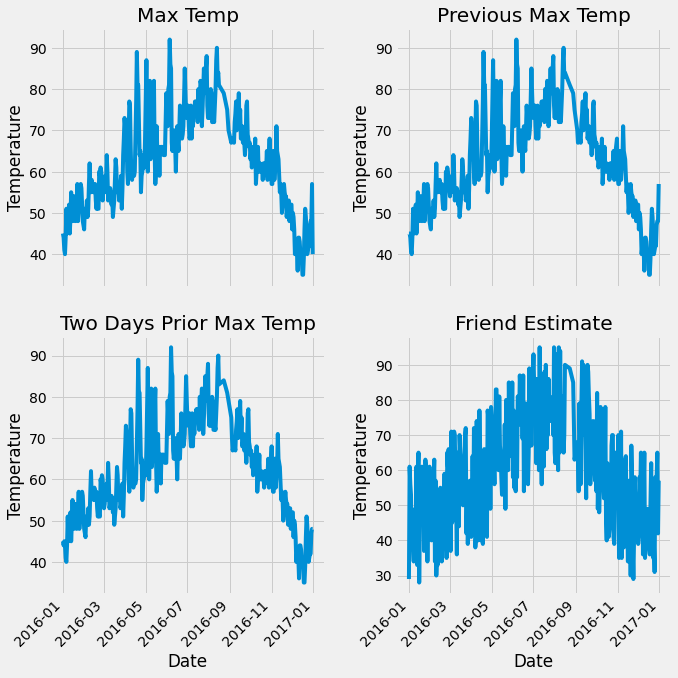

In [8]:
# 准备画图
# 指定默认风格
plt.style.use('fivethirtyeight')

# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,
                                             ncols=2,
                                             figsize=(10, 10))
fig.autofmt_xdate(rotation=45)

# 标签值
ax1.plot(dates, features['actual']) # 所用数据列
ax1.set_xlabel('') # x轴数据
ax1.set_ylabel('Temperature') # y轴数据
ax1.set_title('Max Temp') # 图表标题

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel('')
ax2.set_ylabel('Temperature')
ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date')
ax3.set_ylabel('Temperature')
ax3.set_title('Two Days Prior Max Temp')

# 朋友预测值（意义不大）
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date')
ax4.set_ylabel('Temperature')
ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

In [9]:
# 独热编码（字符串数据转为数值形式）
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [10]:
# 标签
labels = np.array(features['actual'])

# 在特征中去掉标签
# axis = 1 表示沿着每一行或者列标签横向执行对应的方法
# https://blog.csdn.net/wyf2017/article/details/107459509
features = features.drop('actual', axis=1)

# 每列的名字单独保存一下，以备后患
feature_list = list(features.columns)

# 转换成合适的格式
# np.array()把列表转化为数组
features = np.array(features)

In [11]:
labels

array([45, 44, 41, 40, 44, 51, 45, 48, 50, 52, 45, 49, 55, 49, 48, 54, 50,
       54, 48, 52, 52, 57, 48, 51, 54, 56, 57, 56, 52, 48, 47, 46, 51, 49,
       49, 53, 49, 51, 57, 62, 56, 55, 58, 55, 56, 57, 53, 51, 53, 51, 51,
       60, 59, 61, 60, 57, 53, 58, 55, 59, 57, 64, 60, 53, 54, 55, 56, 55,
       52, 54, 49, 51, 53, 58, 63, 61, 55, 56, 57, 53, 54, 57, 59, 51, 56,
       64, 68, 73, 71, 63, 69, 60, 57, 68, 77, 76, 66, 59, 58, 60, 59, 59,
       60, 68, 77, 89, 81, 81, 73, 64, 65, 55, 59, 60, 61, 64, 61, 68, 77,
       87, 74, 60, 68, 77, 82, 63, 67, 75, 81, 77, 82, 65, 57, 60, 71, 64,
       63, 66, 59, 66, 65, 66, 66, 65, 64, 64, 64, 71, 79, 75, 71, 80, 81,
       92, 86, 85, 67, 65, 67, 65, 70, 66, 60, 67, 71, 67, 65, 70, 76, 73,
       75, 68, 69, 71, 78, 85, 79, 74, 73, 76, 76, 71, 68, 69, 76, 68, 74,
       71, 74, 74, 77, 75, 77, 76, 72, 80, 73, 78, 82, 81, 71, 75, 80, 85,
       79, 83, 85, 88, 76, 73, 77, 73, 75, 80, 79, 72, 72, 73, 72, 76, 80,
       87, 90, 83, 84, 81

In [12]:
feature_list

['year',
 'month',
 'day',
 'temp_2',
 'temp_1',
 'average',
 'friend',
 'week_Fri',
 'week_Mon',
 'week_Sat',
 'week_Sun',
 'week_Thurs',
 'week_Tues',
 'week_Wed']

In [13]:
features

array([[2.016e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.016e+03, 1.000e+00, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.016e+03, 1.000e+00, 3.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.016e+03, 1.200e+01, 2.900e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [2.016e+03, 1.200e+01, 3.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.016e+03, 1.200e+01, 3.100e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [14]:
features.shape

(348, 14)

In [15]:
from sklearn import preprocessing

# 不仅计算训练数据的均值和方差，还会基于计算出来的均值和方差来转换训练数据，从而把数据转换成标准的正太分布
input_features = preprocessing.StandardScaler().fit_transform(features)

In [16]:
features[0]

array([2.016e+03, 1.000e+00, 1.000e+00, 4.500e+01, 4.500e+01, 4.560e+01,
       2.900e+01, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00])

In [17]:
input_features[0]

array([ 0.        , -1.5678393 , -1.65682171, -1.48452388, -1.49443549,
       -1.3470703 , -1.98891668,  2.44131112, -0.40482045, -0.40961596,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

In [18]:
print(type(input_features))

<class 'numpy.ndarray'>


### 构建网络模型

In [31]:
x = torch.tensor(input_features, dtype=float)

y = torch.tensor(labels, dtype=float)

# 权重参数初始化，构建2层神经网络 （只有1个隐含层）
# [348,14]->[14,128]->[128,1]（输入层->隐含层->输出层）
# 第1层有128个神经元
# randn，从标准正态分布中返回⼀个或多个样本值
weights = torch.randn((14, 128), dtype=float, requires_grad=True) #权值矩阵w
biases = torch.randn(128, dtype=float, requires_grad=True) # 偏置向量b
# 第2层有1个神经元
weights2 = torch.randn((128, 1), dtype=float, requires_grad=True)
biases2 = torch.randn(1, dtype=float, requires_grad=True)

learning_rate = 0.001
losses = []

for i in range(1000):
    # 计算隐层
    hidden = x.mm(weights) + biases
    # 加入激活函数
    hidden = torch.relu(hidden)
    # 预测结果
    predictions = hidden.mm(weights2) + biases2
    # 通计算损失
    loss = torch.mean((predictions - y)**2)
    losses.append(loss.data.numpy())

    # 打印损失值
    if i % 100 == 0:
        print('loss:', loss)
    #返向传播计算
    loss.backward()

    #更新参数
    weights.data.add_(-learning_rate * weights.grad.data)
    biases.data.add_(-learning_rate * biases.grad.data)
    weights2.data.add_(-learning_rate * weights2.grad.data)
    biases2.data.add_(-learning_rate * biases2.grad.data)

    # 每次迭代都得记得清空
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()

loss: tensor(4378.8550, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(156.1447, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(147.6418, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(144.8679, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(143.4154, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(142.5159, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.8821, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.4163, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.0639, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(140.7854, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [20]:
predictions.shape

torch.Size([348, 1])

### 更简单的构建网络模型

In [21]:
input_size = input_features.shape[1] #样本个数
hidden_size = 128 # 隐含层神经元个数
output_size = 1
batch_size = 16
my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size), #全连接层
    torch.nn.Sigmoid(), #激活函数
    torch.nn.Linear(hidden_size, output_size),
)
# MSE损失函数
cost = torch.nn.MSELoss(reduction='mean')

# Adam优化器
optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)

In [30]:
# 训练网络
losses = []
for i in range(1000):
    batch_loss = []
    # MINI-Batch方法来进行训练
    for start in range(0, len(input_features), batch_size):
        end = start + batch_size if start + batch_size < len(
            input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end],
                          dtype=torch.float,
                          requires_grad=True)
        yy = torch.tensor(labels[start:end],
                          dtype=torch.float,
                          requires_grad=True)
        prediction = my_nn(xx)# 前向传播
        loss = cost(prediction, yy) # 计算损失
        optimizer.zero_grad() # 梯度清零
        loss.backward(retain_graph=True) #反向传播
        optimizer.step() # 更新参数
        batch_loss.append(loss.data.numpy()) #记录损失，便于打印

    # 打印损失
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 34.38214
100 34.252792
200 34.120964
300 33.988102
400 33.85364
500 33.716076
600 33.573933
700 33.426205
800 33.27164
900 33.11107


预测训练结果

In [23]:
x = torch.tensor(input_features, dtype=torch.float)

# 转换成numpy格式便于画图
predict = my_nn(x).data.numpy()

In [24]:
print(type(predict))

<class 'numpy.ndarray'>


In [25]:
predict

array([[47.323746],
       [47.572937],
       [47.070812],
       [47.06005 ],
       [47.438408],
       [46.8778  ],
       [47.456123],
       [48.73009 ],
       [48.50866 ],
       [49.63799 ],
       [50.950497],
       [49.73601 ],
       [49.479584],
       [50.572372],
       [49.364643],
       [49.401993],
       [51.49832 ],
       [51.948723],
       [52.423027],
       [51.192104],
       [50.92473 ],
       [50.607685],
       [52.248367],
       [52.556175],
       [51.892403],
       [52.936344],
       [53.466698],
       [53.601555],
       [53.469406],
       [53.367535],
       [52.345833],
       [50.17077 ],
       [50.726654],
       [51.309566],
       [51.199978],
       [51.258377],
       [52.24337 ],
       [51.87966 ],
       [52.604336],
       [54.29733 ],
       [55.55287 ],
       [55.10769 ],
       [54.585262],
       [55.14422 ],
       [55.74159 ],
       [55.0355  ],
       [54.727394],
       [54.700394],
       [53.89936 ],
       [54.56666 ],


In [26]:
# 转换日期格式
dates = [
    str(int(year)) + '-' + str(int(month)) + '-' + str(int(day))
    for year, month, day in zip(years, months, days)
]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data={'date': dates, 'actual': labels})

# 同理，再创建一个来存日期和其对应的模型预测值
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

test_dates = [
    str(int(year)) + '-' + str(int(month)) + '-' + str(int(day))
    for year, month, day in zip(years, months, days)
]

test_dates = [
    datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates
]

predictions_data = pd.DataFrame(data={
    'date': test_dates,
    'prediction': predict.reshape(-1)
})

Text(0.5, 1.0, 'Actual and Predicted Values')

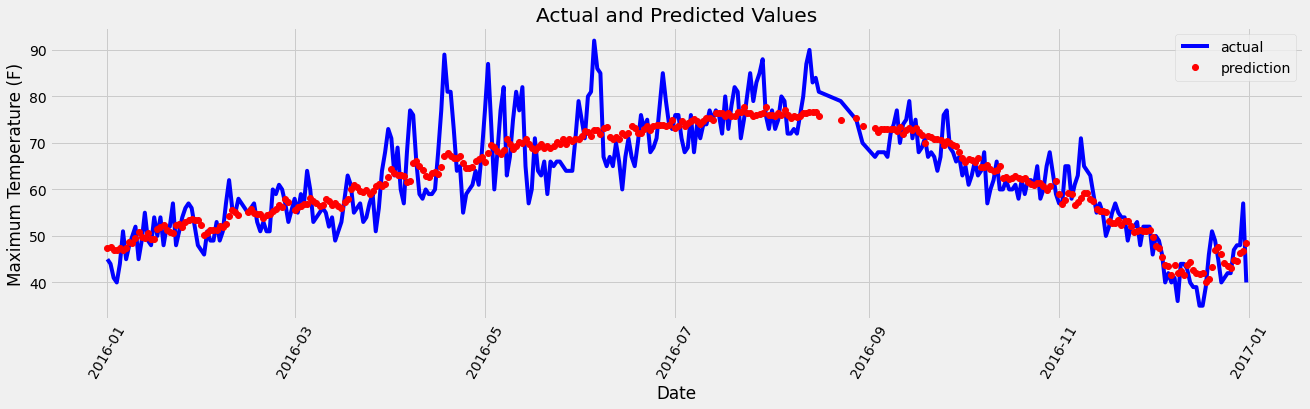

In [32]:
plt.figure(figsize=(20,5))

# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label='actual')

# 预测值
plt.plot(predictions_data['date'],
         predictions_data['prediction'],
         'ro',
         label='prediction')
plt.xticks(rotation='60')
plt.legend()

# 图名
plt.xlabel('Date')
plt.ylabel('Maximum Temperature (F)')
plt.title('Actual and Predicted Values')